In [2]:
import pandas as pd
import plotly.graph_objs as go
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_plotly
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import beta, gamma, halfnorm, laplace, norm, truncnorm
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
freq = "D"
file_path = f"../data/{freq}_preprocessed_data.csv"
data = pd.read_csv(file_path)
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

In [4]:
data

,demand,demand_proxy,tv_ad_spend_raw,social_ad_spend_raw,search_ad_spend_raw,sales
date,,,,,,
2021-01-03,272.515960,270.316305,1418.616426,5931.415947,5707.238400,351.675602
2021-01-04,209.960661,211.611690,2390.720840,2837.504860,4421.170800,296.353601
2021-01-05,289.498515,231.650902,4653.089039,4066.729978,4631.660020,420.215947
2021-01-06,377.975130,412.610037,2234.013683,4601.921825,8008.348062,513.168934
2021-01-07,203.199088,210.239703,2147.635245,2784.604762,3323.354878,307.142275
...,...,...,...,...,...,...
2023-12-29,483.387659,557.511952,3584.266702,8656.036271,14063.037094,708.216797
2023-12-30,487.810809,418.348640,4922.057126,2111.017311,10873.500493,672.695606
2023-12-31,565.282626,550.209233,2002.711193,12704.399563,10039.300416,772.664549


# Preparation for Modeling

<a id="Preparation_for_Modeling"></a>

We want to create some functions that we will call again and again. Hence we will be creating a test and train split 

## Train and test split

<a id="Train_test_split"></a>

We will be splitting the series into train and test. We will not be splitting the train for a validation set as we have a limited number of data.

In [5]:
def train_test_split_time_series(df, test_size=0.3):
    """
    Splits a time series DataFrame into train and test sets while preserving time order.

    Parameters:
        df (pd.DataFrame): Time series DataFrame with a datetime index.
        test_size (float): Proportion of the dataset to use as the test set (e.g., 0.3 for 30%).

    Returns:
        pd.DataFrame, pd.DataFrame: Train and test DataFrames.
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a DatetimeIndex.")

    split_index = int(len(df) * (1 - test_size))  # Determine the split index
    train = df.iloc[:split_index]  # Take the first (1 - test_size)% for training
    test = df.iloc[split_index:]   # Take the last test_size% for testing

    return train, test

train_df, test_df = train_test_split_time_series(data, test_size=0.2)

In [6]:
print(f'The Train data has time range :Shape {train_df.shape} | {train_df.index[0]} to {train_df.index[-1]}')
print(f'The Test data has time range :Shape {test_df.shape} | {test_df.index[0]} to {test_df.index[-1]}' )

The Train data has time range :Shape (876, 6) | 2021-01-03 00:00:00 to 2023-05-28 00:00:00
The Test data has time range :Shape (219, 6) | 2023-05-29 00:00:00 to 2024-01-02 00:00:00


## Defining functions for plotting predictions and forecast

<a id="plotting_func"></a>

In [7]:
def plot_forecast(train_set, test_set, fc_series:pd.Series) -> None:
    """
    This function plots the train, test and forecast values.
    ---
    Args:
        train_df:  training dataframe with datetime index and only one column y
        test_df :  test dataframe with datetime index and only one column y
        fc_series: forecast series 
        
    Returns: None
    """
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_set.index, y=train_set.values, mode='lines', name="Train"))
    fig.add_trace(go.Scatter(x=test_set.index, y=test_set.values, mode='lines', name="Test"))
    fig.add_trace(go.Scatter(x=fc_series.index, y=fc_series.values, mode='lines', name="Forecast"))

    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(
        yaxis_title="Revenue amount", 
        xaxis_title="Date",
        title="Daily Sales amount and forecast"
    )
    fig.show("svg")


In [8]:
def plot_test_predictions(test_set, predictions) -> None:
    """
    This functions plots test set vs predicted values.
    ---
    Args:
        test_df : test dataframe with datetime index and only one column y
        predictions (predictions): prediction values (array or list)
    
    Returns: None
    """
    test_set=pd.Series(test_set, index= test_set.index)
    predictions=pd.Series(predictions, index= test_set.index)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test_set.index, y=test_set.values, mode='lines', name="Test"))
    fig.add_trace(go.Scatter(x=predictions.index, y=predictions.values, mode='lines', name="Predictions"))

    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(
        yaxis_title="Revenue amount for test and predicted values", 
        xaxis_title="Date",
        title="Daily revenue amount"
    )
    fig.show("svg")


## Defining functions for evaluation

<a id="evaluation_metrics"></a>

Throughout this notebook we will be using these two function to evaluate the performance of our model. We will be defining functions to calculate MAPE and RMSE. If we have Y as actual value and Predictions as predicted value for n number of observations then:

MAPE (Mean Absolute Percentage Error): It is a simple average of absolute percentage errors. It is calculated by 

$$ \frac{1}{n} \sum_{i=1}^{n} {| \frac{Y_{actual_i} - Predictions_{i}}{Y_{actual_i}} |} \times{100} $$

RMSE (Root Mean Sqaured Error) : It is the square root of the average of the squared difference between the original and predicted values in the data set. 

$$ \sqrt{\frac{1}{n} \sum_{i=1}^{n} {{(Y_{actual_i} - Predictions_{i})}^2 }} $$

In [9]:
def mape_metrics(test_set, predicted) -> float:
    """
    This function calculates the MAPE.
    ---
    Args:
        test_set (pd.Series):  test set filtered series with y
        predicted (pd.Series):  predicted series
        
    Returns: float MAPE percentage
    """
    # Calculate the MAPE value and return
    mape_result=round(np.mean(np.abs((test_set - predicted) / test_set)) * 100, 2)
    return mape_result

def rmse_metrics(test_set, predicted) -> float:
    """
    This function calculates the RMSE.
    ---
    Args:
        test_set (pd.Series):  test set filtered series with y
        predicted (pd.Series):  predicted series
        
    Returns: float RMSE
    """  
    # Calculate the MAPE value and return
    return round(np.sqrt(np.mean((test_set - predicted)**2)),2)

# SARIMA

<a id="SARIMA"></a>

We will start with SARIMA model to account for the seasonality in our model. SARIMA is Seasonal Autoregressive Integrated Moving Average, which explicitly supports univariate time series data with a seasonal component. Before jumping on to modelling, we need to get a basic understanding of what orders for Auto gregressive and Moving average to choose. We will plot the ACF and PACF plots to find it out.

ACF : Auto correlation function, describes correlation between original and lagged series.
PACF : Partial correlation function is same as ACF but it removes all intermediary effects of shorter lags, leaving only the direct effect visible.

## Plotting ACF and PACF plot

<a id="ACF_PACF"></a>

In [1]:
def plot_acf_pacf(df, acf_lags: int, pacf_lags: int) -> None:
    """
    This function plots the Autocorrelation and Partial Autocorrelation lags.
    ---
    Args:
        df (pd.DataFrame): Dataframe contains the order count and dates.
        acf_lags (int): Number of ACF lags
        pacf_lags (int): Number of PACF lags
    Returns: None
    """
    
    # Figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7), facecolor='w')
    
    # ACF & PACF
    plot_acf(df, ax=ax1, lags=acf_lags)
    plot_pacf(df, ax=ax2, lags=pacf_lags, method='ywm')

    # Labels
    ax1.set_title(f"Autocorrelation {df.name}", fontsize=15, pad=10)
    ax1.set_ylabel("Conversion amount", fontsize=12)
    ax1.set_xlabel("Lags (Days)", fontsize=12)

    ax2.set_title(f"Partial Autocorrelation {df.name}", fontsize=15, pad=10)
    ax2.set_ylabel("Conversion amount", fontsize=12)
    ax2.set_xlabel("Lags (Days)", fontsize=12)
    
    # Legend & Grid
    ax1.grid(linestyle=":", color='grey')
    ax2.grid(linestyle=":", color='grey')

    plt.show()

In [3]:
#plotting the ACF and PACF plot for original series
plot_acf_pacf(data['conversion'], acf_lags=56, pacf_lags= 56)

NameError: name 'data' is not defined

**Observation:**

ACF plot:
 - It shows that there are a lot of significant lags. *In ACF plot none of the lags are becoming zero.* **It means that our data is not stationary as we have explained using statistic test and observation of rolling mean and standard deviation.**
 - It will be hard to determing the AR and MA order, we will need to difference it so that we can identify some significant lags.
 - We can see that Lag peaks after evry 7 days. This is the seasonlity of the model.
    
PACF plot:
 - PACF model has a few significant lags but the plot is not decaying much and has a very little oscillation. So it is hard to say or identify if moving averages can be utilized on this model.
 


In [12]:
# Differencing with previous day
data["day_difference"] = data["sales"].diff(1)
# Double differencing the column sales
data['double_difference'] = data['day_difference'].diff(7)

In [13]:
data

,demand,demand_proxy,tv_ad_spend_raw,social_ad_spend_raw,search_ad_spend_raw,sales,day_difference,double_difference
date,,,,,,,,
2021-01-03,272.515960,270.316305,1418.616426,5931.415947,5707.238400,351.675602,NaN,NaN
2021-01-04,209.960661,211.611690,2390.720840,2837.504860,4421.170800,296.353601,-55.322000,NaN
2021-01-05,289.498515,231.650902,4653.089039,4066.729978,4631.660020,420.215947,123.862346,NaN
2021-01-06,377.975130,412.610037,2234.013683,4601.921825,8008.348062,513.168934,92.952987,NaN
2021-01-07,203.199088,210.239703,2147.635245,2784.604762,3323.354878,307.142275,-206.026658,NaN
...,...,...,...,...,...,...,...,...
2023-12-29,483.387659,557.511952,3584.266702,8656.036271,14063.037094,708.216797,0.324756,-283.614863
2023-12-30,487.810809,418.348640,4922.057126,2111.017311,10873.500493,672.695606,-35.521191,178.220975
2023-12-31,565.282626,550.209233,2002.711193,12704.399563,10039.300416,772.664549,99.968943,81.155021


We will plot the ACF and PACF plot by differencing means differencing the day_difference with seasonal differnce data.

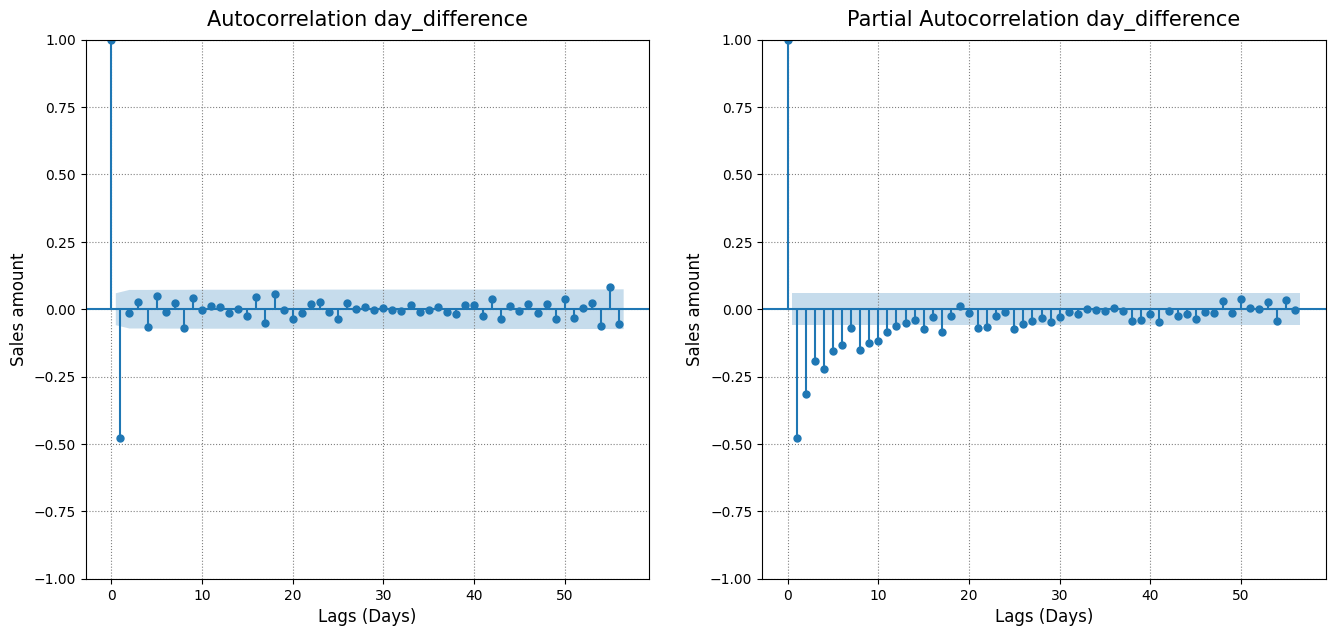

In [14]:
# Plotting the ACF and PACF plot for double differenced series
plot_acf_pacf(data['day_difference'].dropna(), acf_lags=56, pacf_lags= 56)

We will try to plot the ACF and PACF plot by double differencing means differencing the day_difference with seasonal differnce data.

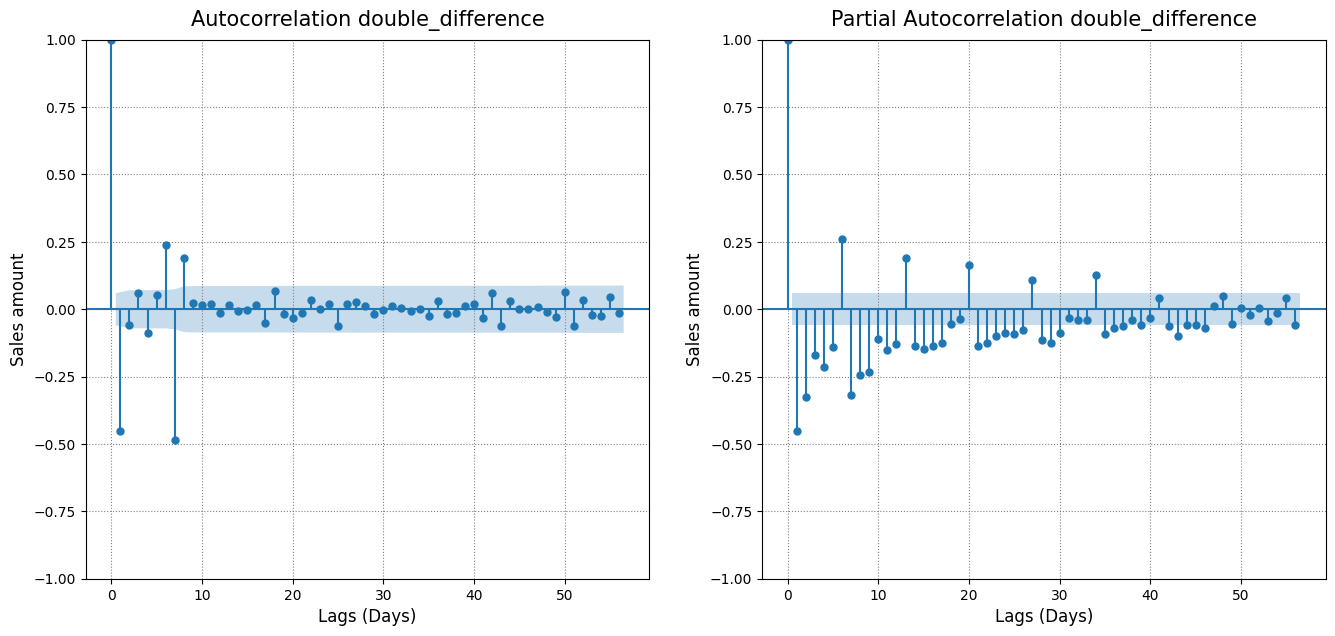

In [15]:
# Plotting the ACF and PACF plot for double differenced series
plot_acf_pacf(data['double_difference'].dropna(), acf_lags=56, pacf_lags= 56)

**Observation:**

It little difficult to tell, what values of  p and  q are appropriate for the data but we will try to find the appropriate orders.

ACF plot:
- A lot of lags have become zero now. There are few lags that are significant 1, 4, 6, 7 and 8. 
- We can use non seasonal MA of order 1, 4, 6 but the most significant lag is 1.
- The lag at 7 is also important and can help determing the seasonal MA component.

PACF plot:
- It shows signigicant peaks at every seasonal lag of 7 days and peaks are diminishing. Also the non-seasonal lags are also diminishing. So we can use seasonl and non-seasonal MA components in model. The MA components can be determined using the significant lags from ACF plot.
- Apart from seasonl lags, the lag of 1, 2 and 3 are also significant. We can one of these lags for our non-seasonl AR component. 

## Applying SARIMA model  <a name="Baseline"></a>
---

The SARIMA model is specified 

$$SARIMA(p, d, q) \times (P, D, Q)_s$$

Where:
- Trend Elements are:
    - p: Autoregressive order
    - d: Difference order
    - q: Moving average order
- Seasonal Elements are:
    - P: Seasonal autoregressive order.
    - D: Seasonal difference order. D=1 would calculate a first order seasonal difference
    - Q: Seasonal moving average order. Q=1 would use a first order errors in the model
    - s: Single seasonal period

#### Theoretical estimates:
- **s**: In our PACF plot there is peak that reappears every 7 days. Thus, we can set seasonal period to **s = 7**. This also backed by our seasonal component after additive decomposition.
- **p**: We observed that there is some tappering in ACF plot and we found the significant lags of 1,2,3 from PACF plot. We can start with **p=1** and see how it works. 
- **d**: We observed that our series has some trend, so we can remove it by differencing, so **d = 1**.
- **q**: Based on our ACF correlations we can set **q = 1** since its the most significant lag. 
- **P**: **P = 0** as we are using ACF plot to find seasonl significant lag. 
- **D**: Since we are dealing with seasonality and we need to differnce the series, **D = 1**
- **Q**: The seasonal moving average will be set to **Q = 1** as we found only one significant seasonal lag in ACF plot. 
Here we go:

$$ SARIMA(1, 1, 1) \times (0, 1, 1)_{7} $$

### Baseline Sarima Model

In [16]:
# Set Hyper-parameters
p, d, q = 1, 1, 1
P, D, Q = 0, 1, 1
s = 7

# Fit SARIMA
sarima_model = SARIMAX(train_df['sales'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_model_fit = sarima_model.fit(disp=0)
print(sarima_model_fit.summary())

/home/boiqm/anaconda3/envs/mmm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/boiqm/anaconda3/envs/mmm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                  876
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -5454.168
Date:                           Fri, 07 Mar 2025   AIC                          10916.336
Time:                                   10:09:48   BIC                          10935.400
Sample:                               01-03-2021   HQIC                         10923.631
                                    - 05-28-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0636      0.035      1.802      0.072      -0.006       0.133
ma.L1         -0.9631      0.010    -93.742

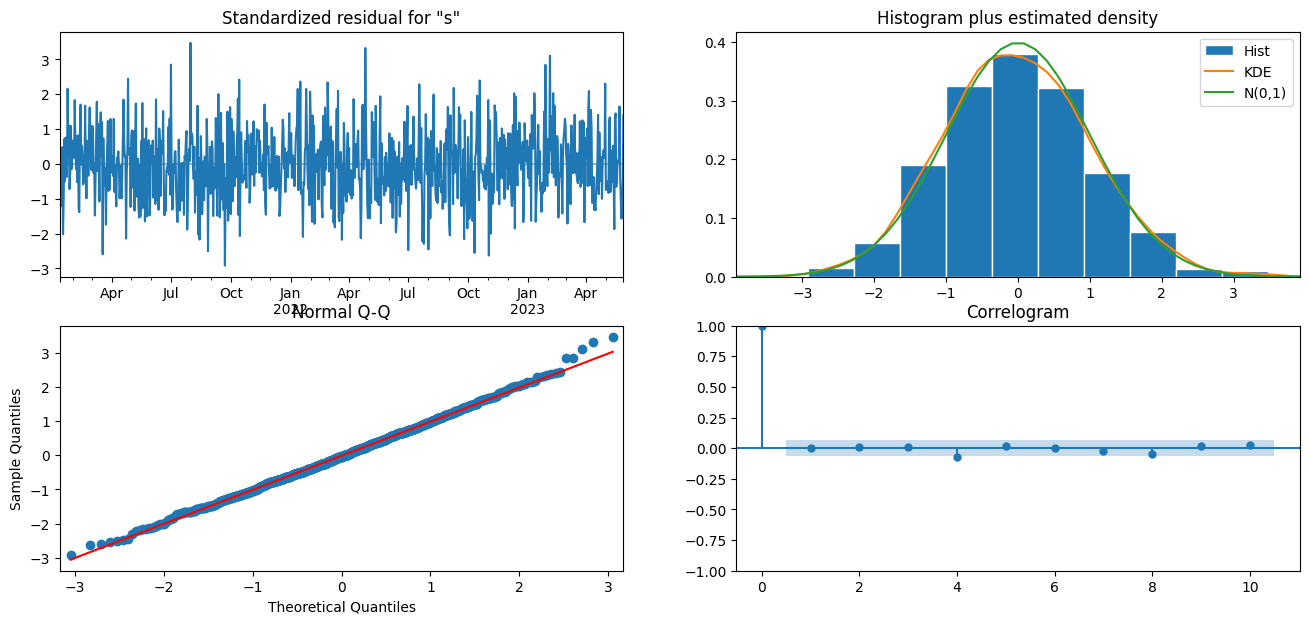

In [17]:
# Plot diagnostics
sarima_model_fit.plot_diagnostics(figsize=(16,7))
plt.show()

**Observations:**
- **The standardize residual plot:**  The residuals appear as white noise. It looks like the residual of the decomposed time series.
- **The Normal Q-Q-plot:** Shows that the ordered distribution of residuals follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). There are some outlier as we have seen earlier.
- **Histogram and estimated density plot:**  The KDE follows the N(0,1) line however with noticeable differences. As mentioned before our distribution has heavier tails.
- **The Correlogram plot:** Shows that the time series residuals have low correlation with lagged versions of itself. Meaning there are no patterns left to extract in the residuals.

Lets test the model on our training set:

## Plotting predictions and evaluating SARIMA model
<a id="plot"></a>

#### Prediction using SARIMA

In [18]:
# defining prediction period
pred_start_date = test_df.index[0]
pred_end_date = test_df.index[-1]

sarima_predictions = sarima_model_fit.predict(start=pred_start_date, end=pred_end_date)
sarima_residuals = test_df['sales'] - sarima_predictions

#### Evaluation of SARIMA

In [19]:
# Get evaluation data
sarima_root_mean_squared_error = rmse_metrics(test_df['sales'], sarima_predictions)
sarima_mape_error = mape_metrics(test_df['sales'], sarima_predictions)

print(f'Root Mean Squared Error | RMSE: {sarima_root_mean_squared_error}')
print(f'Mean Absolute Percentage Error | MAPE: {sarima_mape_error}')

Root Mean Squared Error | RMSE: 170.7
Mean Absolute Percentage Error | MAPE: 24.39


We are able to get a MAPE of 24.39 % and RMSE of 170.7. 

#### Plotting test and prediction

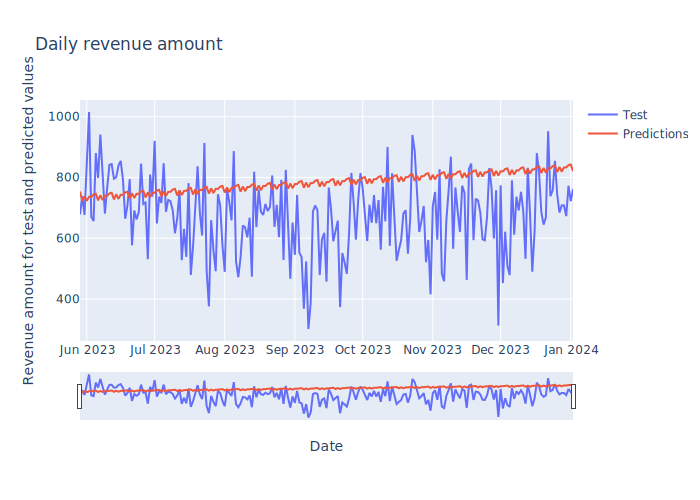

In [20]:
plot_test_predictions(test_df['sales'], sarima_predictions)

**Observations:**

Our baseline model is able to capture the seasonality and trend component but is not able to pick up the variations between weeks. The MAPE is also very high.

### Sarima Forecast

We will try to forecast the sales for next 270 days. We have the 219 days known from our test data and we will try to see what our model forcasts for next 270 - 219 = 51 days.

In [21]:
# Forecast Window
days = 270

sarima_forecast = sarima_model_fit.forecast(days)
sarima_forecast_series = pd.Series(sarima_forecast, index=sarima_forecast.index)

# Since negative orders are not possible we can trim them.
sarima_forecast_series[sarima_forecast_series < 0] = 0

#### Plotting Forecast using baseline SARIMA

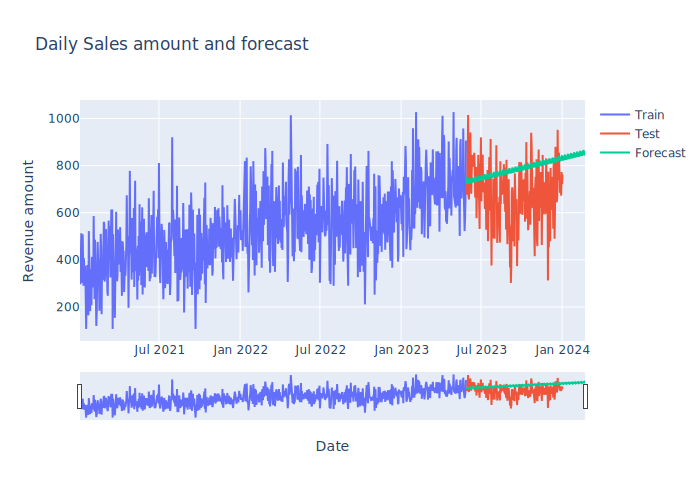

In [22]:
plot_forecast(train_df['sales'], test_df['sales'], sarima_forecast_series)

**Observations:**

- The model predicts the overall daily patterns pretty well. 
- Is not performning well to pick up the variation between weeks and months.
- It positively trending and is not capturing the peaks and toughs.
- We will need to tune it further and should also add another feature holiday so that it can pick some informations from that.
- While this model doesn't have a great long term predictive power it can serve as a solid baseline for our next models.

# Facebook Prophet

<a id="FB_Prophet"></a>

FB Prophet is a forecasting package in Python that was developed by Facebook’s data science research team. The goal of the package is to give business users a powerful and easy-to-use tool to help forecast business results without needing to be an expert in time series analysis. We will apply this model and see how it performs.

## Preparing data for FB Prophet

<a id="fb_prep"></a>

Faecbook prophet needs data in a certain format to be able to process it. The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement here in our case it is total_amount.

In [23]:
#preparing the dataframe for fbProphet

prophet_df=data['sales'].reset_index()
prophet_df.rename(columns={"index": "ds", "sales": "y"}, inplace=True)

#using our original train_df and test_df we will convert them into prophet train andt test set.
prophet_train = train_df["sales"].reset_index()
prophet_train.rename(columns={"date": "ds", "sales": "y"}, inplace=True)
prophet_test = test_df["sales"].reset_index()
prophet_test.rename(columns={"date": "ds", "sales": "y"}, inplace=True)

In [24]:
prophet_df.head()

,date,y
0,2021-01-03,351.675602
1,2021-01-04,296.353601
2,2021-01-05,420.215947
3,2021-01-06,513.168934
4,2021-01-07,307.142275


## Applying a Baseline FB Prophet

<a id="fb_baseline"></a>

Since we observed that our data has positive trend and seasonality, we will set growth ='linear' and let the model find out appropriate seasonality by making yearly_seaonality, daily_seasonality and weekly_seasonality = True.

In [25]:
#instantiate the model
fb_baseline = Prophet(growth='linear', 
                yearly_seasonality=True, 
                daily_seasonality=True, 
                weekly_seasonality=True)
fb_baseline.fit(prophet_train)

10:09:49 - cmdstanpy - INFO - Chain [1] start processing


10:09:49 - cmdstanpy - INFO - Chain [1] done processing


#### Predictions using baseline Prophet

In [26]:
#make predictions dataframe 
future_base = fb_baseline.make_future_dataframe(periods=len(test_df), freq="D")

In [27]:
#make a forecast
forecast_base = fb_baseline.predict(future_base)
forecast_base[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1090,2023-12-29,762.347772,611.811093,910.676006
1091,2023-12-30,765.977329,598.097219,941.225948
1092,2023-12-31,776.453163,607.856703,945.784635
1093,2024-01-01,780.764445,628.818750,941.463712
1094,2024-01-02,760.596962,600.812509,915.674746


In [28]:
forecast_base[-219:].reset_index()['yhat']


0      708.483925
1      684.069718
2      698.373911
3      680.698098
4      692.323590
          ...    
214    762.347772
215    765.977329
216    776.453163
217    780.764445
218    760.596962
Name: yhat, Length: 219, dtype: float64

## Plotting and Evaluating Baseline model

<a id="fb_plot"></a>

In [29]:
#evaluating on test set
fb_baseline_mape = mape_metrics(prophet_test['y'], forecast_base[-219:].reset_index()['yhat'] )
fb_baseline_rmse = rmse_metrics(prophet_test['y'], forecast_base[-219:].reset_index()['yhat'] )

print(f'Root Mean Squared Error | RMSE: {fb_baseline_rmse}')
print(f'Mean Absolute Percentage Error | MAPE: {fb_baseline_mape}')

Root Mean Squared Error | RMSE: 128.68
Mean Absolute Percentage Error | MAPE: 16.87


#### Plotting the forecast using Baseline FB Prophet

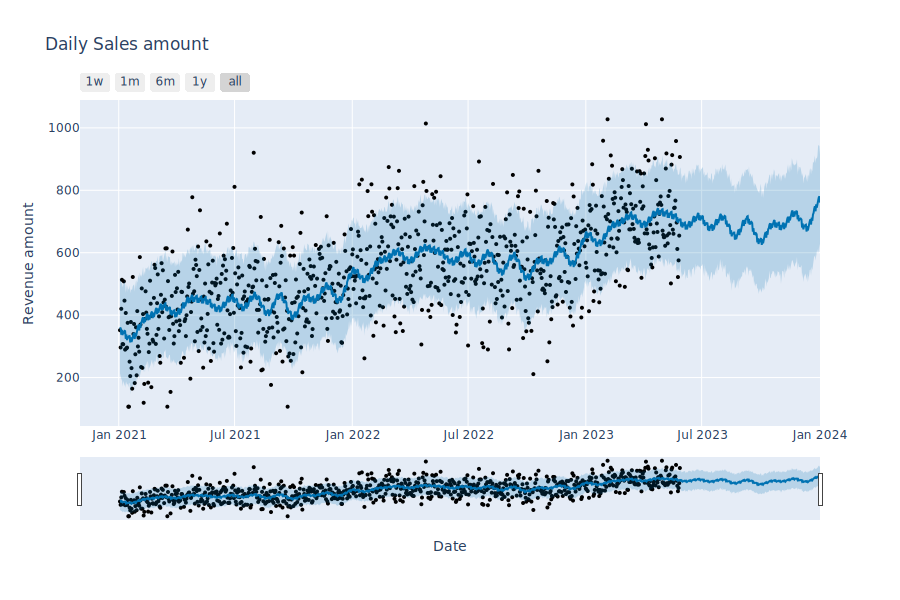

In [30]:
fig = plot_plotly(fb_baseline, forecast_base) 
fig.update_layout(
    title="Daily Sales amount",
    xaxis_title="Date",
    yaxis_title="Revenue amount"
    )
# fig.show()
fig.show("svg")

# Bayesian Modelling

In [31]:
data

,demand,demand_proxy,tv_ad_spend_raw,social_ad_spend_raw,search_ad_spend_raw,sales,day_difference,double_difference
date,,,,,,,,
2021-01-03,272.515960,270.316305,1418.616426,5931.415947,5707.238400,351.675602,NaN,NaN
2021-01-04,209.960661,211.611690,2390.720840,2837.504860,4421.170800,296.353601,-55.322000,NaN
2021-01-05,289.498515,231.650902,4653.089039,4066.729978,4631.660020,420.215947,123.862346,NaN
2021-01-06,377.975130,412.610037,2234.013683,4601.921825,8008.348062,513.168934,92.952987,NaN
2021-01-07,203.199088,210.239703,2147.635245,2784.604762,3323.354878,307.142275,-206.026658,NaN
...,...,...,...,...,...,...,...,...
2023-12-29,483.387659,557.511952,3584.266702,8656.036271,14063.037094,708.216797,0.324756,-283.614863
2023-12-30,487.810809,418.348640,4922.057126,2111.017311,10873.500493,672.695606,-35.521191,178.220975
2023-12-31,565.282626,550.209233,2002.711193,12704.399563,10039.300416,772.664549,99.968943,81.155021


## Data Preparation

## Understanding the model and default priors

### Intercept
The baseline level of sales or target variable in the absence of any marketing spend or other variables. It sets the starting point for the model.

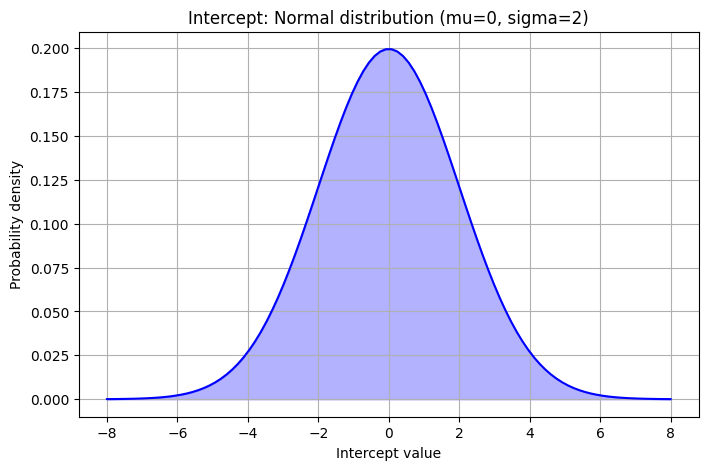

In [32]:
mu = 0
sigma = 2

x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
y = norm.pdf(x, mu, sigma)

plt.figure(figsize=(8, 5))
plt.plot(x, y, color='blue')
plt.fill_between(x, y, color='blue', alpha=0.3)
plt.title('Intercept: Normal distribution (mu=0, sigma=2)')
plt.xlabel('Intercept value')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

### Gamma control

 Control variables that account for external factors, such as macroeconomic conditions, holidays, or other non-marketing variables that might influence sales.

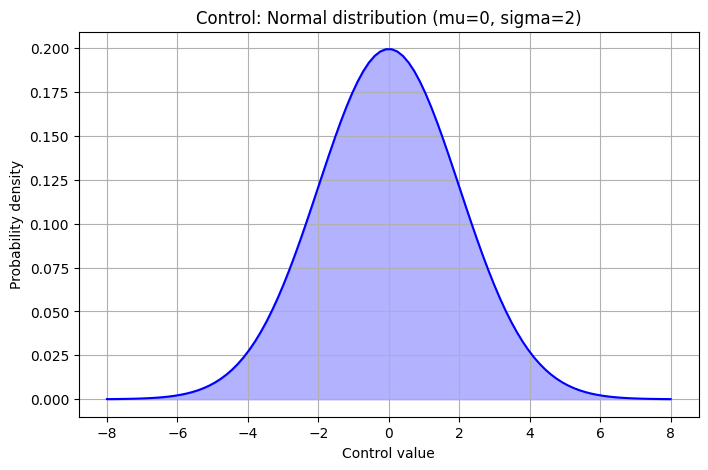

In [33]:
mu = 0
sigma = 2

x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
y = norm.pdf(x, mu, sigma)

plt.figure(figsize=(8, 5))
plt.plot(x, y, color='blue')
plt.fill_between(x, y, color='blue', alpha=0.3)
plt.title('Control: Normal distribution (mu=0, sigma=2)')
plt.xlabel('Control value')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

### Seasonality

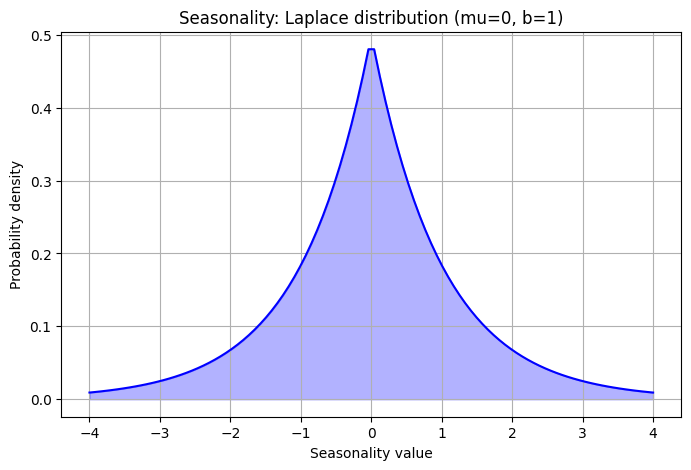

In [34]:
mu = 0
b = 1

x = np.linspace(mu - 4*b, mu + 4*b, 100)
y = laplace.pdf(x, mu, b)

plt.figure(figsize=(8, 5))
plt.plot(x, y, color='blue')
plt.fill_between(x, y, color='blue', alpha=0.3)
plt.title('Seasonality: Laplace distribution (mu=0, b=1)')
plt.xlabel('Seasonality value')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

### Geometric adstock

Controls the adstock effect, determining how much the impact of marketing spend decays over time.

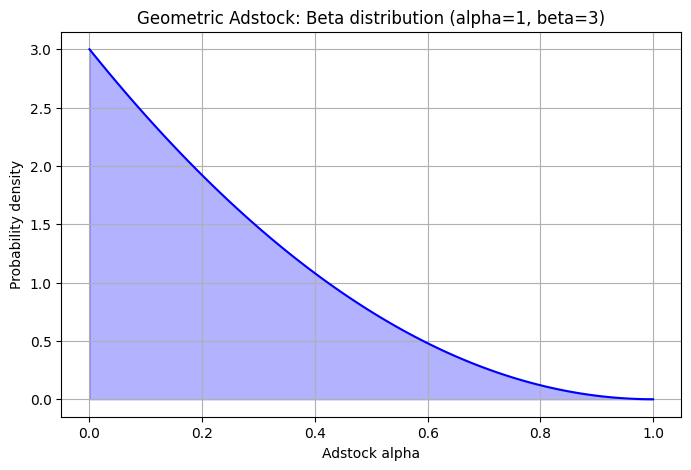

In [35]:
alpha = 1
beta_param = 3

x1 = np.linspace(0, 1, 100)
y1 = beta.pdf(x1, alpha, beta_param)

plt.figure(figsize=(8, 5))
plt.plot(x1, y1, color='blue')
plt.fill_between(x1, y1, color='blue', alpha=0.3)
plt.title('Geometric Adstock: Beta distribution (alpha=1, beta=3)')
plt.xlabel('Adstock alpha')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

We typically constrain adstock alpha values between 0 and 1, making the beta distribution a sensible choice. Specifically, using a beta(1, 3) prior for adstock alpha reflects the belief that, in most cases, the decay rate should be relatively high, meaning the effect of marketing activities wears off quickly.

To build further intuition, we can visualise the effect of different adstock alpha values:

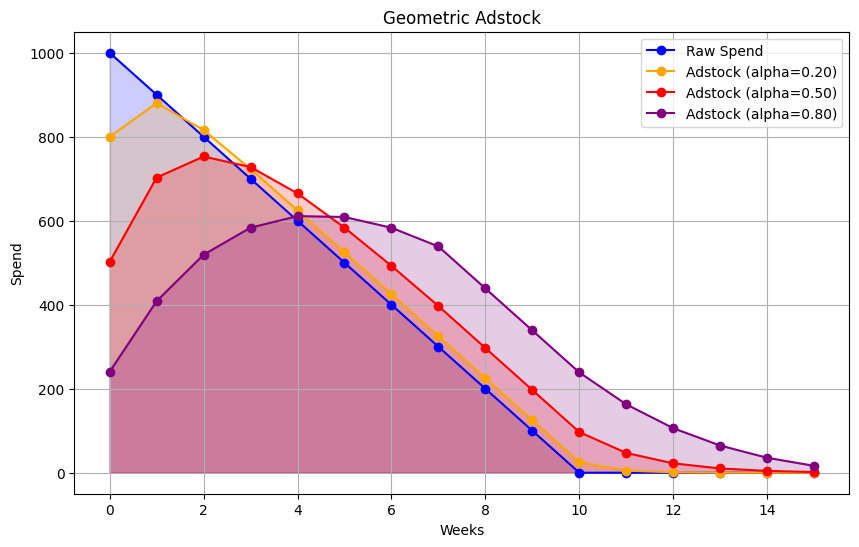

In [36]:
raw_spend = np.array([1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 0, 0, 0, 0, 0, 0])

adstock_spend_1 = geometric_adstock(x=raw_spend, alpha=0.20, l_max=8, normalize=True).eval().flatten()
adstock_spend_2 = geometric_adstock(x=raw_spend, alpha=0.50, l_max=8, normalize=True).eval().flatten()
adstock_spend_3 = geometric_adstock(x=raw_spend, alpha=0.80, l_max=8, normalize=True).eval().flatten()

plt.figure(figsize=(10, 6))

plt.plot(raw_spend, marker='o', label='Raw Spend', color='blue')
plt.fill_between(range(len(raw_spend)), 0, raw_spend, color='blue', alpha=0.2)

plt.plot(adstock_spend_1, marker='o', label='Adstock (alpha=0.20)', color='orange')
plt.fill_between(range(len(adstock_spend_1)), 0, adstock_spend_1, color='orange', alpha=0.2)

plt.plot(adstock_spend_2, marker='o', label='Adstock (alpha=0.50)', color='red')
plt.fill_between(range(len(adstock_spend_2)), 0, adstock_spend_2, color='red', alpha=0.2)

plt.plot(adstock_spend_3, marker='o', label='Adstock (alpha=0.80)', color='purple')
plt.fill_between(range(len(adstock_spend_3)), 0, adstock_spend_3, color='purple', alpha=0.2)

plt.xlabel('Weeks')
plt.ylabel('Spend')
plt.title('Geometric Adstock')
plt.legend()
plt.grid(True)
plt.show()

Low values of alpha have little impact and are suitable for channels which have a direct response e.g. paid social performance ads with a direct call to action aimed at prospects who have already visited your website.

Higher values of alpha have a stronger impact and are suitable for channels which have a longer term effect e.g. brand building videos with no direct call to action aimed at a broad range of prospects.

### Logistic saturation (Saturation lamda)

As we increase marketing spend, it’s incremental impact of sales slowly starts to reduce — This is known as saturation. Saturation lamda controls the steepness of the saturation curve, determining how quickly diminishing returns set in.

A gamma distribution is used as a prior for saturation lambda. Let’s start by understanding what a gamma distribution looks like:

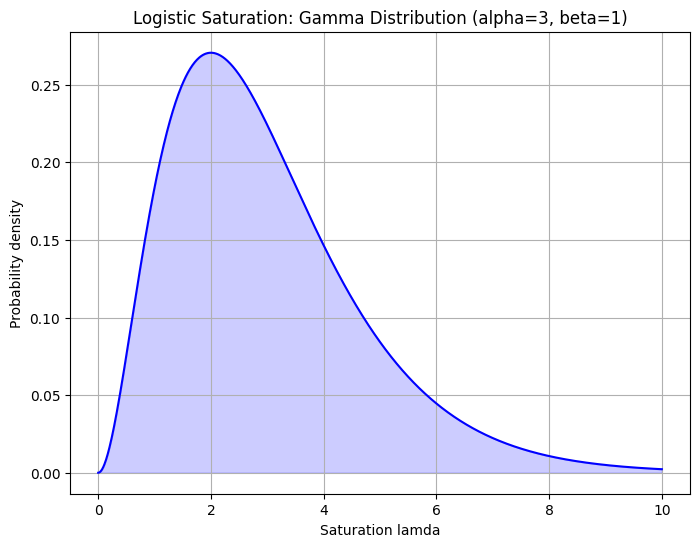

In [37]:
alpha = 3
beta = 1

x2 = np.linspace(0, 10, 1000)
y2 = gamma.pdf(x2, alpha, scale=1/beta)

plt.figure(figsize=(8, 6))
plt.plot(x2, y2, 'b-')
plt.fill_between(x2, y2, alpha=0.2, color='blue')
plt.title('Logistic Saturation: Gamma Distribution (alpha=3, beta=1)')
plt.xlabel('Saturation lamda')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

At first glance it can be difficult to understand why the gamma distribution is a sensible choice of prior but plotting the impact of different lamda values helps clarify its appropriateness:

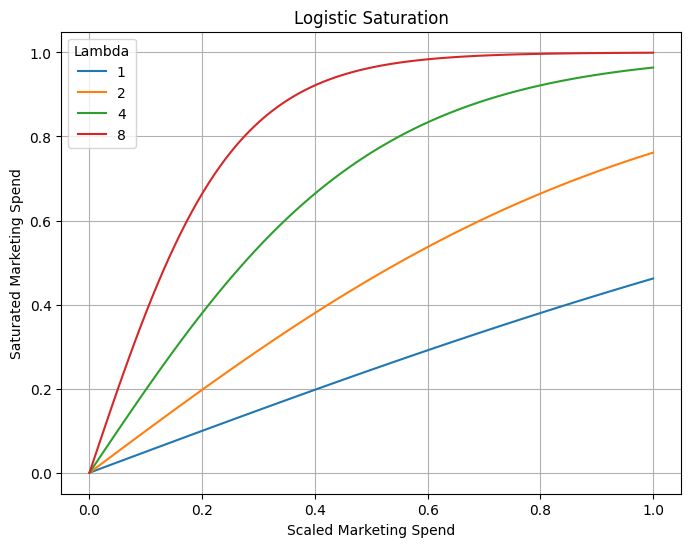

In [38]:
scaled_spend = np.linspace(start=0.0, stop=1.0, num=100)

saturated_spend_1 = logistic_saturation(x=scaled_spend, lam=1).eval()
saturated_spend_2 = logistic_saturation(x=scaled_spend, lam=2).eval()
saturated_spend_4 = logistic_saturation(x=scaled_spend, lam=4).eval()
saturated_spend_8 = logistic_saturation(x=scaled_spend, lam=8).eval()

plt.figure(figsize=(8, 6))
sns.lineplot(x=scaled_spend, y=saturated_spend_1, label="1")
sns.lineplot(x=scaled_spend, y=saturated_spend_2, label="2")
sns.lineplot(x=scaled_spend, y=saturated_spend_4, label="4")
sns.lineplot(x=scaled_spend, y=saturated_spend_8, label="8")

plt.title('Logistic Saturation')
plt.xlabel('Scaled Marketing Spend')
plt.ylabel('Saturated Marketing Spend')
plt.legend(title='Lambda')
plt.grid(True)
plt.show()

* A lamda value of 1 keeps the relationship linear.
* As we increase lamda, the steepness of the saturation curve increases.
* From the chart we hopefully agree that it seems unlikely to have a saturation much steeper than what we see when the lamda value is 8.

### Saturation beta

Saturation beta corresponds to the marketing channel coefficient, measuring the impact of marketing spend.

The half-normal prior is used as it enforces positivity which is a very reasonable assumption e.g. marketing shouldn’t have a negative effect. When sigma is set as 2, it tends towards low values. This helps regularize the coefficients, pulling them towards lower values unless there is strong evidence in the data that a particular channel has a significant impact.

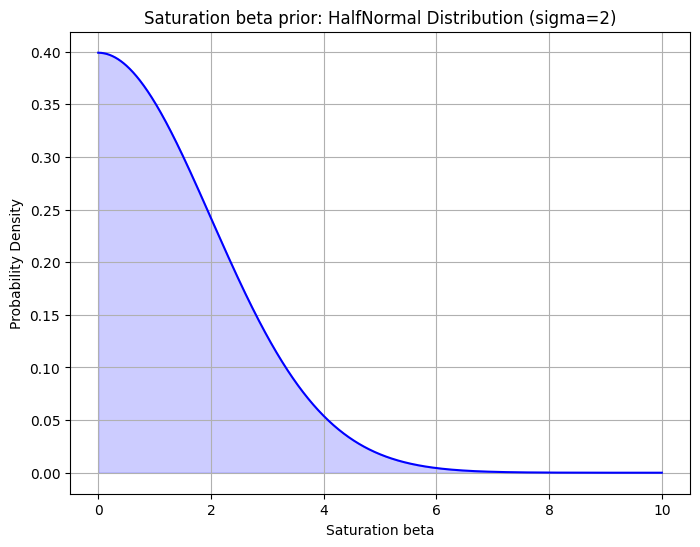

In [39]:
sigma = 2

x3 = np.linspace(0, 10, 1000)
y3 = halfnorm.pdf(x3, scale=sigma)

plt.figure(figsize=(8, 6))
plt.plot(x3, y3, 'b-')
plt.fill_between(x3, y3, alpha=0.2, color='blue')
plt.title('Saturation beta prior: HalfNormal Distribution (sigma=2)')
plt.xlabel('Saturation beta')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

## Fix model

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2021-01-03 to 2024-01-02
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   demand               1095 non-null   float64
 1   demand_proxy         1095 non-null   float64
 2   tv_ad_spend_raw      1095 non-null   float64
 3   social_ad_spend_raw  1095 non-null   float64
 4   search_ad_spend_raw  1095 non-null   float64
 5   sales                1095 non-null   float64
 6   day_difference       1094 non-null   float64
 7   double_difference    1087 non-null   float64
dtypes: float64(8)
memory usage: 77.0 KB


In [41]:
data

,demand,demand_proxy,tv_ad_spend_raw,social_ad_spend_raw,search_ad_spend_raw,sales,day_difference,double_difference
date,,,,,,,,
2021-01-03,272.515960,270.316305,1418.616426,5931.415947,5707.238400,351.675602,NaN,NaN
2021-01-04,209.960661,211.611690,2390.720840,2837.504860,4421.170800,296.353601,-55.322000,NaN
2021-01-05,289.498515,231.650902,4653.089039,4066.729978,4631.660020,420.215947,123.862346,NaN
2021-01-06,377.975130,412.610037,2234.013683,4601.921825,8008.348062,513.168934,92.952987,NaN
2021-01-07,203.199088,210.239703,2147.635245,2784.604762,3323.354878,307.142275,-206.026658,NaN
...,...,...,...,...,...,...,...,...
2023-12-29,483.387659,557.511952,3584.266702,8656.036271,14063.037094,708.216797,0.324756,-283.614863
2023-12-30,487.810809,418.348640,4922.057126,2111.017311,10873.500493,672.695606,-35.521191,178.220975
2023-12-31,565.282626,550.209233,2002.711193,12704.399563,10039.300416,772.664549,99.968943,81.155021


In [42]:
# set date column
date_col = "date"

# set outcome column
y_col = "sales"

# set marketing variables
channel_cols = ["tv_ad_spend_raw",
                "social_ad_spend_raw",
                "search_ad_spend_raw"]

# set control variables
control_cols = ["demand_proxy"]

# Reset index (convert date index to a column)
mmm_data = data.copy()
mmm_data = mmm_data.reset_index()

# Rename the date column (optional)
mmm_data = mmm_data.rename(columns={'index': 'date'})

# create arrays
X = mmm_data[[date_col] + channel_cols + control_cols]
y = mmm_data[y_col]

# set test (out-of-sample) length
test_len = 219

# create train and test indexs
train_idx = slice(0, len(mmm_data) - test_len)
out_of_time_idx = slice(len(mmm_data) - test_len, len(mmm_data))

In [43]:
X[train_idx].shape, X[out_of_time_idx].shape

((876, 5), (219, 5))

In [44]:
mmm_default = MMM(
    adstock=GeometricAdstock(l_max=8), #219
    saturation=LogisticSaturation(),
    date_column=date_col,
    channel_columns=channel_cols,
    control_columns=control_cols,
)

mmm_default.default_model_config

{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2, dims="channel")}

Now let’s fit the model using the train indices. I’ve passed some optional key-word-arguments, let’s spend a bit of time understanding what they do:

* Tune — This sets the number of tuning steps for the sampler. During tuning, the sampler adjusts its parameters to efficiently explore the posterior distribution. These initial 1,000 samples are discarded and not used for inference.
* Chains — This specifies the number of independent Markov chains to run. Running multiple chains helps assess convergence and provides a more robust sampling of the posterior.
* Draws — This sets the number of samples to draw from the posterior distribution per chain, after tuning.
* Target accept — This is the target acceptance rate for the sampler. It helps balance exploration of the parameter space with efficiency.

In [45]:
fit_kwargs = {
    "tune": 1_000,
    "chains": 4,
    "draws": 1_000,
    "target_accept": 0.9,
}

mmm_default.fit(X[train_idx], y[train_idx], **fit_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 214 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

In [46]:
mmm_default.save("mmm_default.nc")

## Validate model

After fitting the model, the first step is to check for divergences. Divergences indicate potential problems with either the model or the sampling process. Although delving deeply into divergences is beyond the scope of this article due to its complexity, it’s essential to note their importance in model validation.

Below, we check the number of divergences in our model. A result of 0 divergences indicates a good start.

In [47]:
mmm_default.idata["sample_stats"]["diverging"].sum().item()

0

Next we can get a comprehensive summary of the MCMC sampling results. Let’s focus on the key ones:

* mean — The average value of the parameter across all samples.
* hdi_3% and hdi_97% — The lower and upper bounds of the 94% Highest Density Interval (HDI). A 94% HDI means that there’s a 94% probability that the true value of the parameter lies within this interval, based on the observed data and prior information.
* rhat — Gelman-Rubin statistic, measuring convergence across chains. Values close to 1 (typically < 1.05) indicate good convergence.

In [48]:
parameters_model = az.summary(
    data=mmm_default.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
    ],
)

In [49]:
parameters_model

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.015,0.007,0.002,0.028,0.000,0.000,2381.0,2580.0,1.0
y_sigma,0.032,0.001,0.031,0.034,0.000,0.000,3490.0,2604.0,1.0
saturation_beta[tv_ad_spend_raw],0.753,0.467,0.285,1.554,0.011,0.008,2053.0,2114.0,1.0
saturation_beta[social_ad_spend_raw],0.566,0.381,0.179,1.210,0.009,0.007,1957.0,2086.0,1.0
saturation_beta[search_ad_spend_raw],0.225,0.153,0.110,0.424,0.005,0.004,1417.0,1063.0,1.0
saturation_lam[tv_ad_spend_raw],0.936,0.415,0.225,1.704,0.009,0.006,1969.0,2016.0,1.0
saturation_lam[social_ad_spend_raw],0.826,0.400,0.178,1.572,0.009,0.006,1939.0,2078.0,1.0
saturation_lam[search_ad_spend_raw],1.508,0.559,0.367,2.466,0.015,0.010,1448.0,1186.0,1.0
adstock_alpha[tv_ad_spend_raw],0.431,0.039,0.356,0.500,0.001,0.001,2941.0,2357.0,1.0
adstock_alpha[social_ad_spend_raw],0.178,0.060,0.067,0.289,0.001,0.001,2584.0,1658.0,1.0


Our R-hats are all very close to 1, which is expected given the absence of divergences. We will revisit the mean parameter values in the next section when we conduct a parameter recovery exercise.

Next, we generate diagnostic plots that are crucial for assessing the quality of our MCMC sampling:

* Posterior Distribution (left): Displays the value of each parameter throughout the MCMC sampling. Ideally, these should be smooth and unimodal, with all chains showing similar distributions.
* Trace Plots (right): Illustrate the value of each parameter over the MCMC sampling process. Any trends or slow drifts may indicate poor mixing or non-convergence, while chains that don’t overlap could suggest they are stuck in different modes of the posterior.

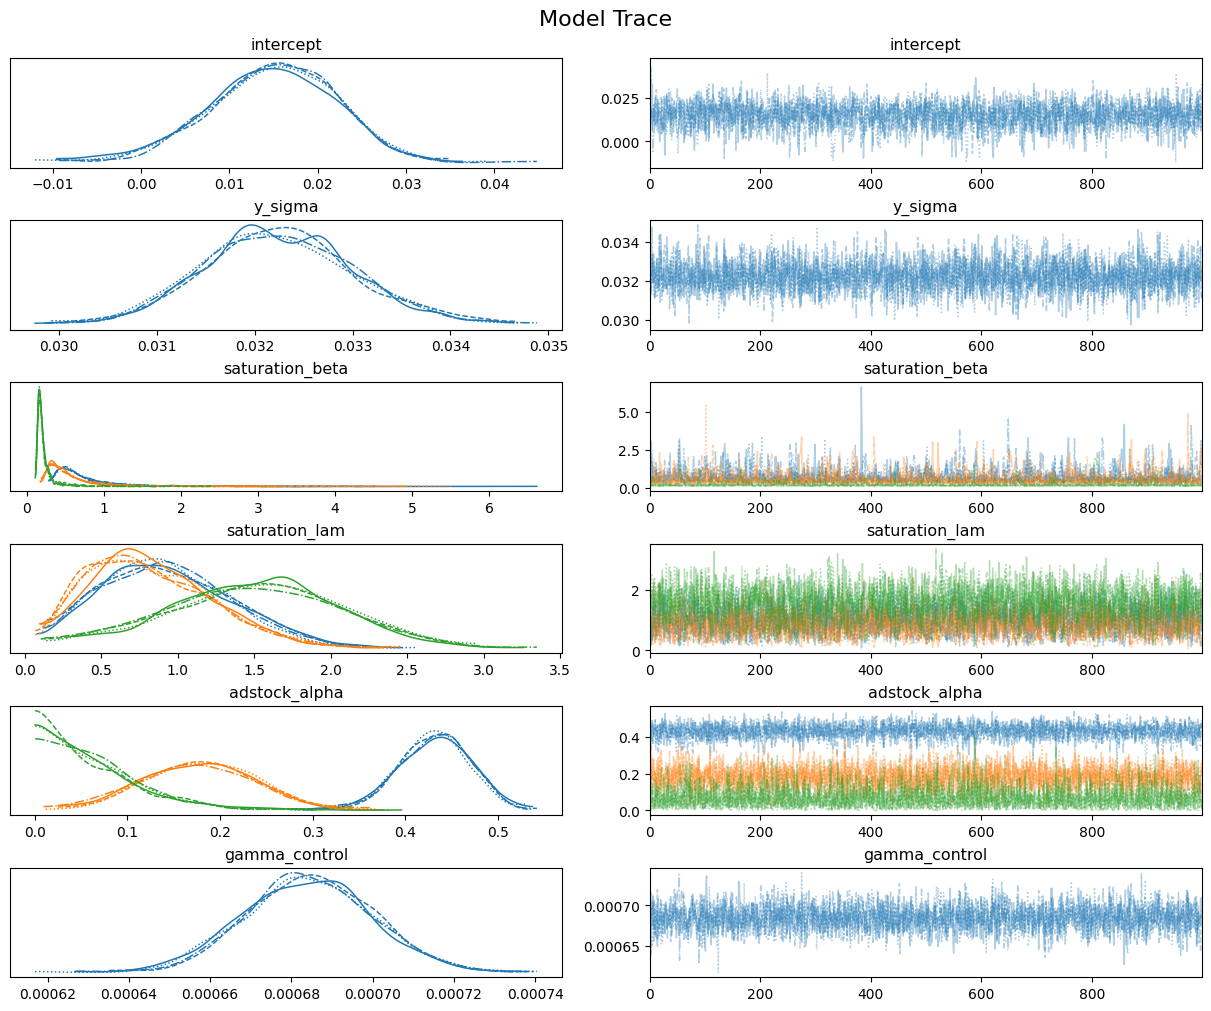

In [50]:
_ = az.plot_trace(
    data=mmm_default.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

For each parameter we have a distribution of possible values which reflects the uncertainty in the parameter estimates. For the next set of diagnostics, we first need to sample from the posterior. This allows us to make predictions, which we will do for the training data.

In [51]:
mmm_default.sample_posterior_predictive(X[train_idx], extend_idata=True, combined=True)

Sampling: [y]


Output()

<xarray.Dataset> Size: 28MB
Dimensions:  (sample: 4000, date: 876)
Coordinates:
  * date     (date) datetime64[ns] 7kB 2021-01-03 2021-01-04 ... 2023-05-28
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 28MB 369.7 310.9 329.8 ... 855.5 955.2 874.4
Attributes:
    created_at:                 2025-03-07T10:13:39.905889+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.15.1

We can begin the posterior predictive checking diagnostics by visually assessing whether the observed data falls within the predicted ranges. It appears that our model has performed well.

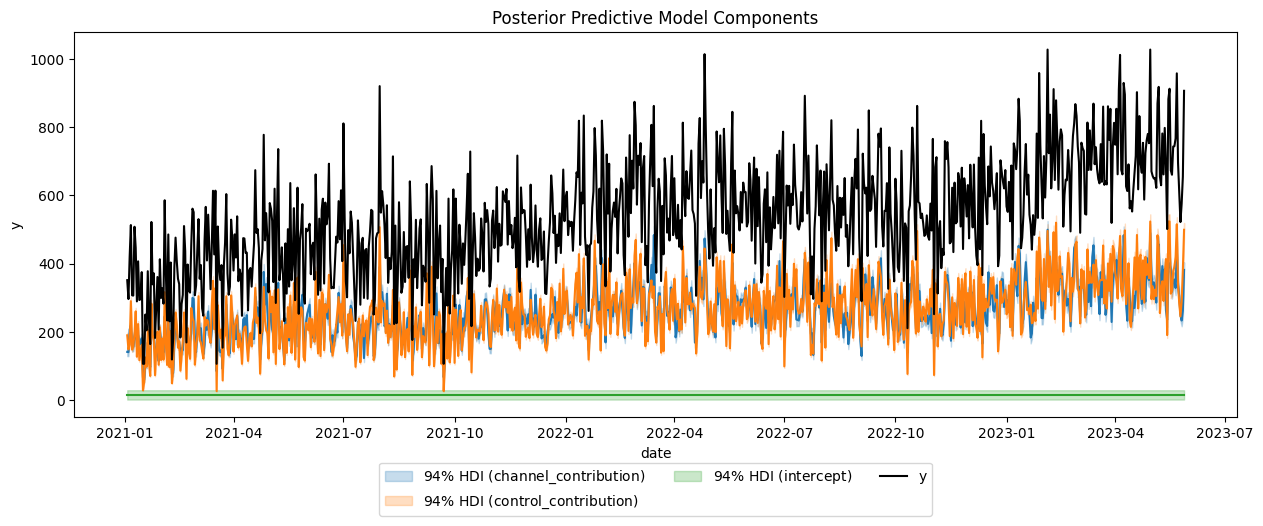

In [52]:
mmm_default.plot_components_contributions(original_scale=True)
# Adjust figure size (increase width for better x-axis spacing)
plt.gcf().set_size_inches(15, 5)  # Example: Width=15 inches, Height=5 inches
plt.show()

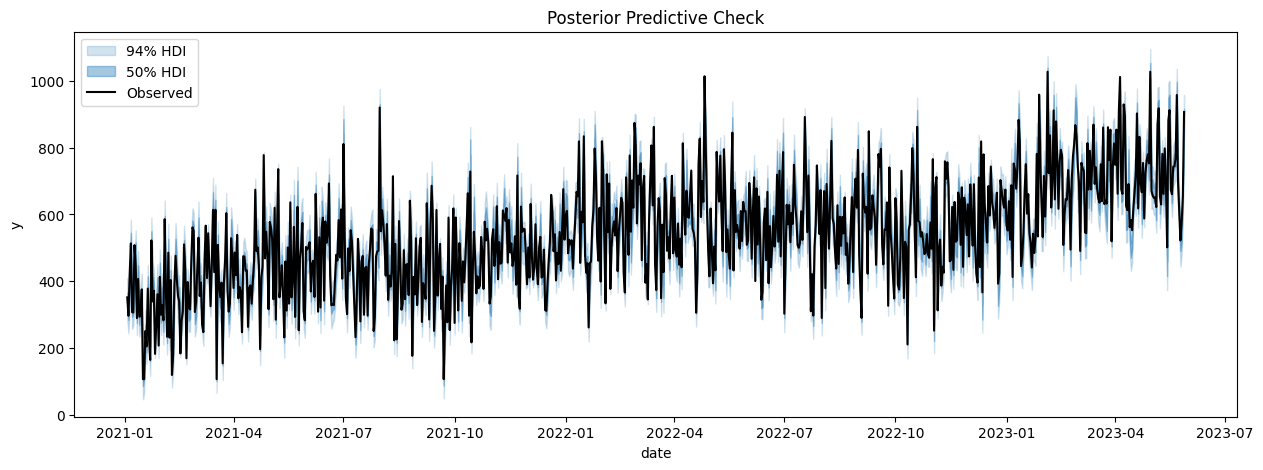

In [53]:
mmm_default.plot_posterior_predictive(original_scale=True)
plt.gcf().set_size_inches(15, 5)  # Example: Width=15 inches, Height=5 inches
plt.show()

Next we can calculate residuals between the posterior predictive mean and the actual data. We can plot these residuals over time to check for patterns or autocorrelation. It looks like the residuals oscillate around 0 as expected.

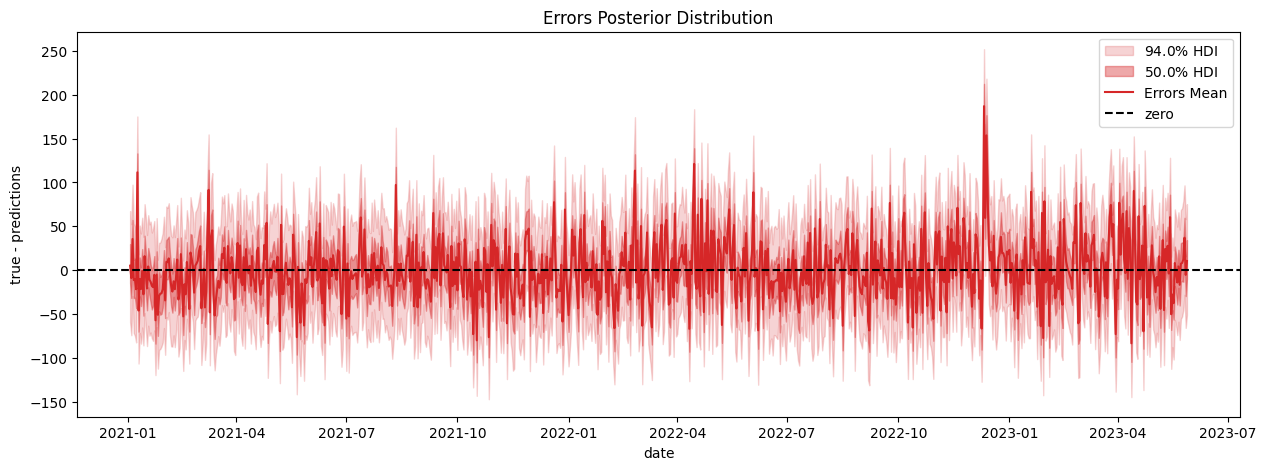

In [54]:
mmm_default.plot_errors(original_scale=True)
plt.gcf().set_size_inches(15, 5)  # Example: Width=15 inches, Height=5 inches
plt.show()

We can also check whether the residuals are normally distributed around 0. Again, we pass this diagnostic test.

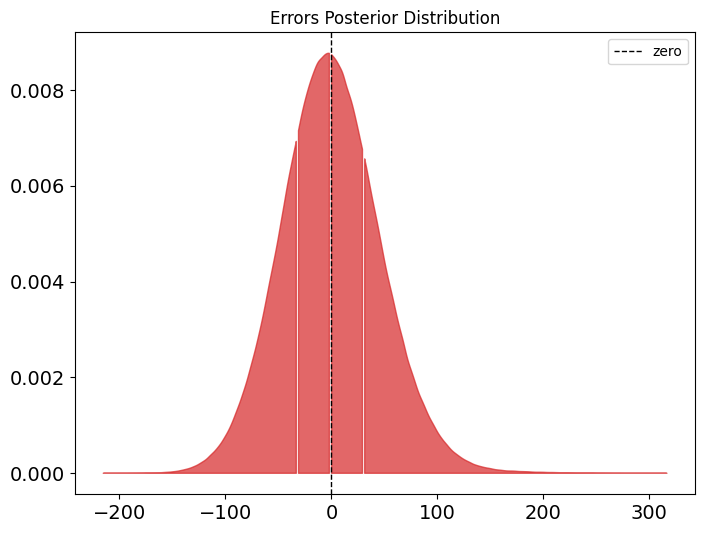

In [55]:
errors = mmm_default.get_errors(original_scale=True)

fig, ax = plt.subplots(figsize=(8, 6))
az.plot_dist(
    errors, quantiles=[0.25, 0.5, 0.75], color="C3", fill_kwargs={"alpha": 0.7}, ax=ax
)
ax.axvline(x=0, color="black", linestyle="--", linewidth=1, label="zero")
ax.legend()
ax.set(title="Errors Posterior Distribution");

Finally it is good practice to assess how good our model is at predicting outside of the training sample. First of all we need to sample from the posterior again but this time using the out-of-time data. We can then plot the observed sales against the predicted.

Below we can see that the observed sales generally lie within the intervals and the model seems to do a good job.

Sampling: [y]


Output()

/tmp/ipykernel_897573/3214283255.py:21: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



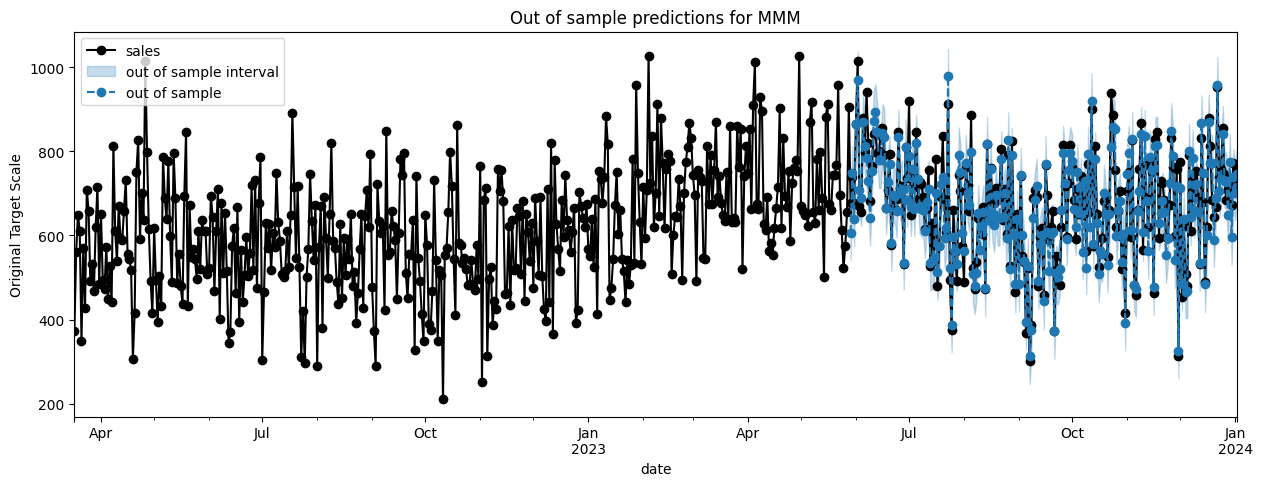

In [56]:
y_out_of_sample = mmm_default.sample_posterior_predictive(
    X_pred=X[out_of_time_idx], extend_idata=False, include_last_observations=True
)

def plot_in_sample(X, y, ax, n_points: int = 15):
    (
        y.to_frame()
        .set_index(X[date_col])
        .iloc[-n_points:]
        .plot(ax=ax, marker="o", color="black", label="actuals")
    )
    return ax


def plot_out_of_sample(X_out_of_sample, y_out_of_sample, ax, color, label):
    y_out_of_sample_groupby = y_out_of_sample["y"].to_series().groupby("date")

    lower, upper = quantiles = [0.025, 0.975]
    conf = y_out_of_sample_groupby.quantile(quantiles).unstack()
    ax.fill_between(
        X_out_of_sample[date_col].dt.to_pydatetime(),
        conf[lower],
        conf[upper],
        alpha=0.25,
        color=color,
        label=f"{label} interval",
    )

    mean = y_out_of_sample_groupby.mean()
    mean.plot(ax=ax, marker="o", label=label, color=color, linestyle="--")
    ax.set(ylabel="Original Target Scale", title="Out of sample predictions for MMM")
    return ax


_, ax = plt.subplots(figsize=(15,5))
plot_in_sample(X, y, ax=ax, n_points=len(X[out_of_time_idx])*3)
plot_out_of_sample(
    X[out_of_time_idx], y_out_of_sample, ax=ax, label="out of sample", color="C0"
)
ax.legend(loc="upper left")


Text(0.5, 0.98, 'Contribution Breakdown over Time')

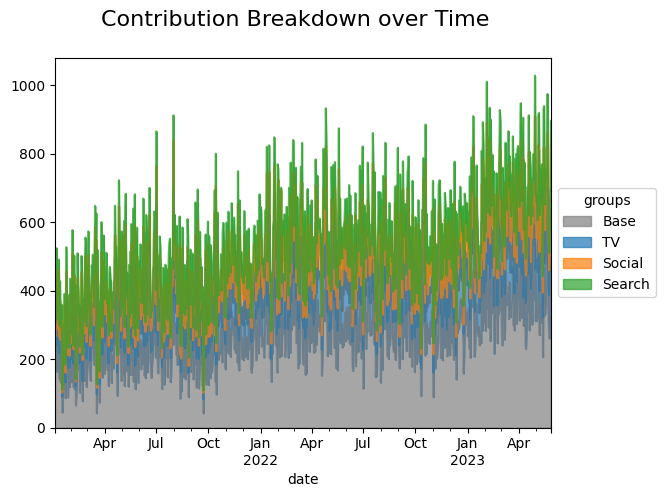

In [57]:
### Contribution Breakdown over time
groups = {
    "Base": [
        "intercept",
        "demand_proxy",
    ],
    "TV": ["tv_ad_spend_raw"],
    "Social": ["social_ad_spend_raw"],
    "Search": ["search_ad_spend_raw"],
}

fig = mmm_default.plot_grouped_contribution_breakdown_over_time(
    stack_groups=groups,
    original_scale=True,
    area_kwargs={
        "color": {
            "TV": "C0",
            "Social": "C1",
            "Search": "C2",            
            "Base": "gray",
        },
        "alpha": 0.7,
    },
)

fig.suptitle("Contribution Breakdown over Time", fontsize=16)

Now, let’s plot the contributions from the model. The rank ordering for demand, TV, social, and search is correct. However, TV, social, and search are all overestimated. This appears to be driven by the demand proxy not contributing as much as true demand.

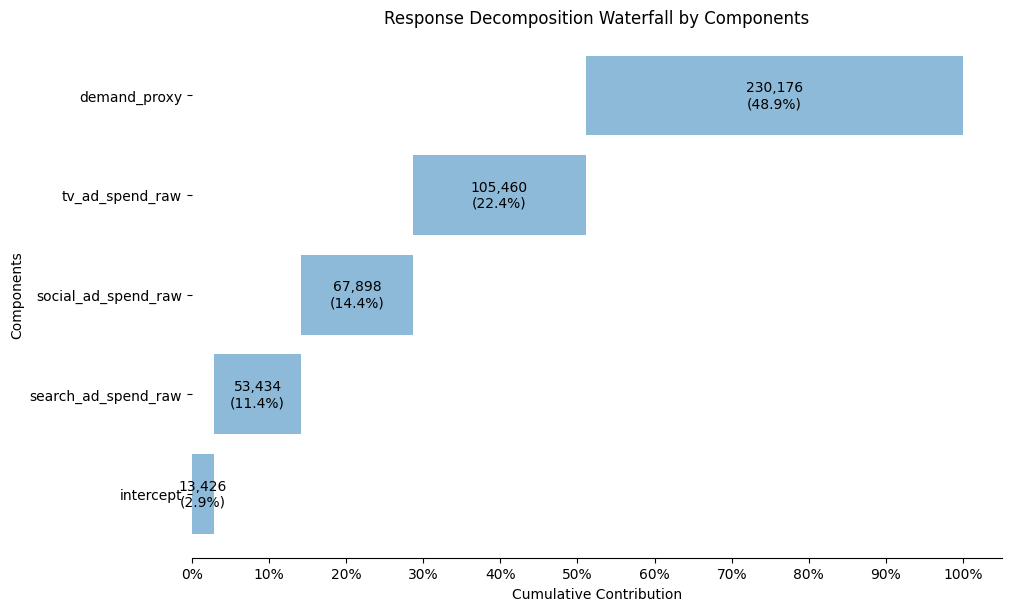

In [58]:
mmm_default.plot_waterfall_components_decomposition(figsize=(10,6));

We can extract the data itself of all the input variables contributions over time, i.e. the regression coefficients times the feature values, as follows:

## Saturation Curve

In [59]:
type(mmm_default.model)

pymc.model.core.Model

In [60]:
print(f"Model was train using the {mmm_default.saturation.__class__.__name__} function")
print(f"and the {mmm_default.adstock.__class__.__name__} function")

Model was train using the LogisticSaturation function
and the GeometricAdstock function


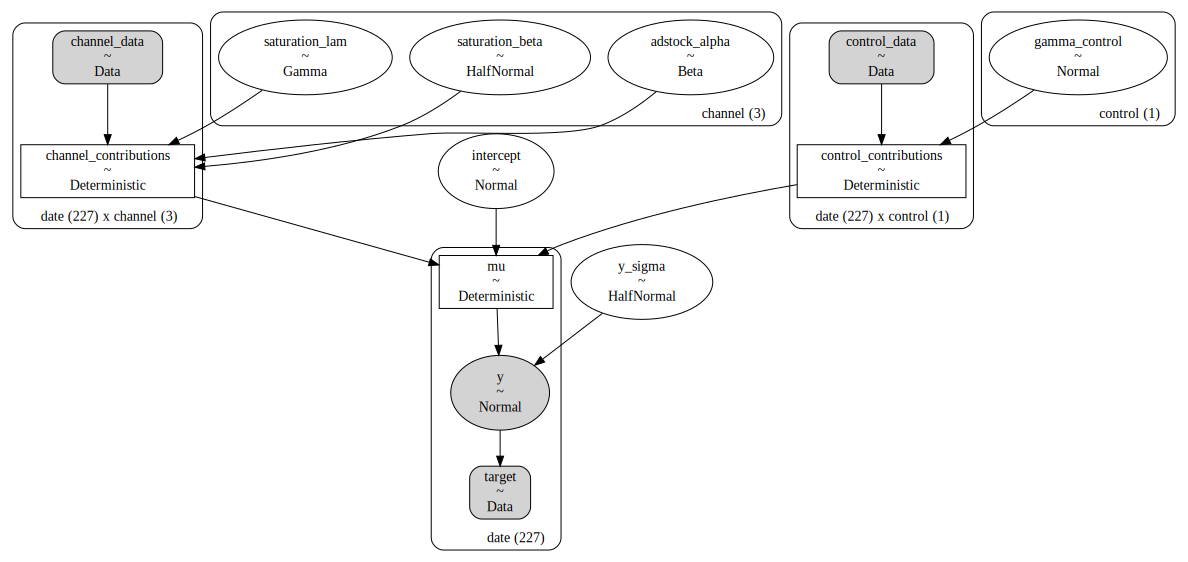

In [61]:
mmm_default.graphviz()

In [62]:
channel_cols

['tv_ad_spend_raw', 'social_ad_spend_raw', 'search_ad_spend_raw']

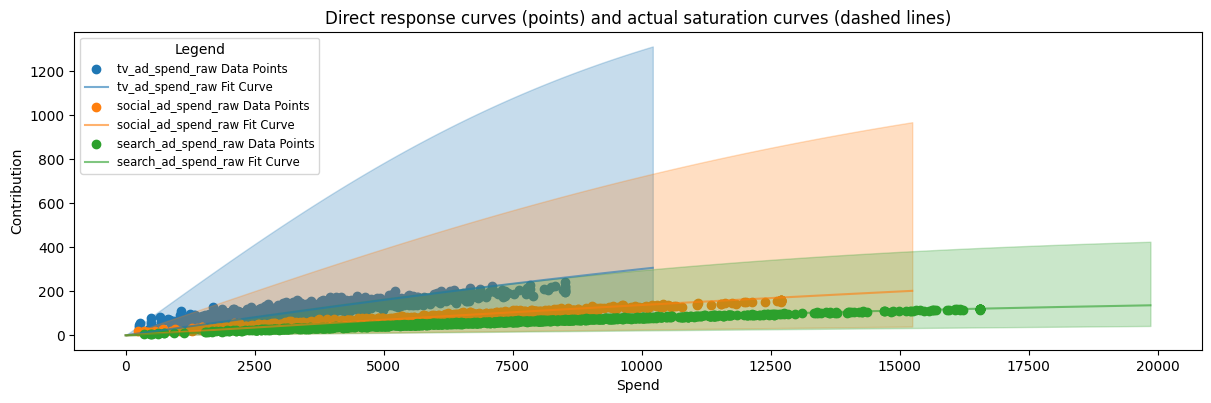

In [68]:
fig = mmm_default.plot_direct_contribution_curves(show_fit=True, xlim_max=1.2, same_axes=True)
# Remove the main figure title
fig.suptitle("")  # This clears the figure title
# Update x-axis label and title for each subplot
for ax in fig.axes:
    ax.set(xlabel="Spend", title="Direct response curves (points) and actual saturation curves (dashed lines)")  # Change "Updated Title" as needed

# Show the updated plot
plt.show()

In [64]:
parameters_model.index

Index(['intercept', 'y_sigma', 'saturation_beta[tv_ad_spend_raw]',
       'saturation_beta[social_ad_spend_raw]',
       'saturation_beta[search_ad_spend_raw]',
       'saturation_lam[tv_ad_spend_raw]',
       'saturation_lam[social_ad_spend_raw]',
       'saturation_lam[search_ad_spend_raw]', 'adstock_alpha[tv_ad_spend_raw]',
       'adstock_alpha[social_ad_spend_raw]',
       'adstock_alpha[search_ad_spend_raw]', 'gamma_control[demand_proxy]'],
      dtype='object')

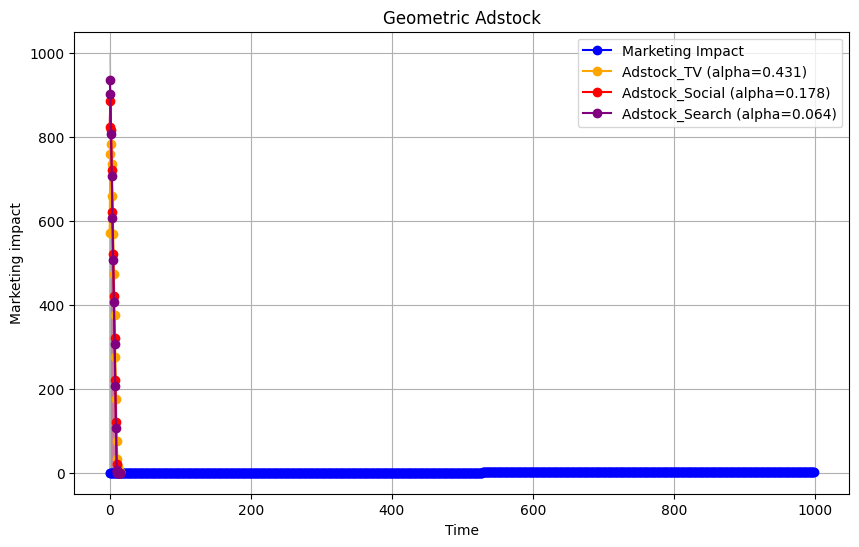

In [65]:
marketing_impact = np.linspace(0, 1, 1000)

alpha_tv = parameters_model[parameters_model.index == 'adstock_alpha[tv_ad_spend_raw]']['mean'].values[0]
alpha_social = parameters_model[parameters_model.index == 'adstock_alpha[social_ad_spend_raw]']['mean'].values[0]
alpha_search = parameters_model[parameters_model.index == 'adstock_alpha[search_ad_spend_raw]']['mean'].values[0]

adstock_tv = geometric_adstock(x=raw_spend, alpha=alpha_tv, l_max=8, normalize=True).eval().flatten()
adstock_social = geometric_adstock(x=raw_spend, alpha=alpha_social, l_max=8, normalize=True).eval().flatten()
adstock_search = geometric_adstock(x=raw_spend, alpha=alpha_search, l_max=8, normalize=True).eval().flatten()

plt.figure(figsize=(10, 6))

plt.plot(marketing_impact, marker='o', label='Marketing Impact', color='blue')
plt.fill_between(range(len(raw_spend)), 0, raw_spend, color='blue', alpha=0.2)

plt.plot(adstock_tv, marker='o', label=f'Adstock_TV (alpha={alpha_tv})', color='orange')
plt.fill_between(range(len(adstock_tv)), 0, adstock_tv, color='orange', alpha=0.2)

plt.plot(adstock_social, marker='o', label=f'Adstock_Social (alpha={alpha_social})', color='red')
plt.fill_between(range(len(adstock_social)), 0, adstock_social, color='red', alpha=0.2)

plt.plot(adstock_search, marker='o', label=f'Adstock_Search (alpha={alpha_search})', color='purple')
plt.fill_between(range(len(adstock_search)), 0, adstock_search, color='purple', alpha=0.2)

plt.xlabel('Time')
plt.ylabel('Marketing impact')
plt.title('Geometric Adstock')
plt.legend()
plt.grid(True)
plt.show()

In [66]:
def geoDecay(alpha, L):
    '''
    weighted average with geometric decay

    weight_T = alpha ^ T-1 

    returns: weights of length L to calculate weighted averages with. 
    '''
    return alpha**(np.ones(L).cumsum()-1)

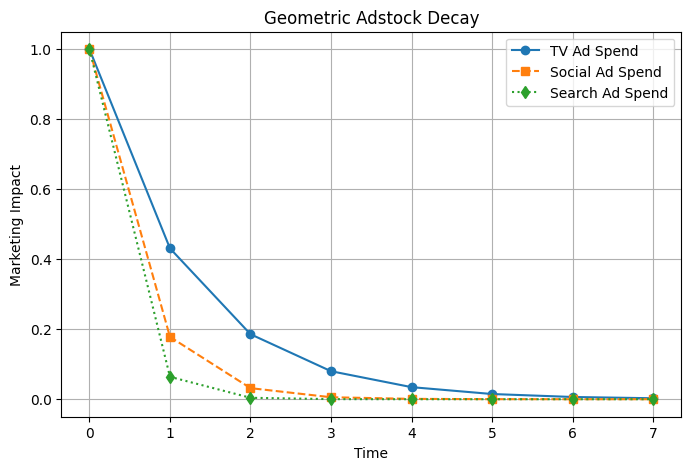

In [67]:
# Define parameters
# Adstock decay parameters from model estimates
alpha_tv = parameters_model.loc['adstock_alpha[tv_ad_spend_raw]', 'mean']
alpha_social = parameters_model.loc['adstock_alpha[social_ad_spend_raw]', 'mean']
alpha_search = parameters_model.loc['adstock_alpha[search_ad_spend_raw]', 'mean']

l_max = 8  # Maximum lag

# Compute the decay effect using geoDecay function
y_tv = geoDecay(alpha_tv, l_max)
y_social = geoDecay(alpha_social, l_max)
y_search = geoDecay(alpha_search, l_max)

# Plot each adstock effect with labels
plt.figure(figsize=(8, 5))
plt.plot(y_tv, label="TV Ad Spend", linestyle="-", marker="o")
plt.plot(y_social, label="Social Ad Spend", linestyle="--", marker="s")
plt.plot(y_search, label="Search Ad Spend", linestyle=":", marker="d")

# Labels and title
plt.xlabel("Time")
plt.ylabel("Marketing Impact")
plt.title("Geometric Adstock Decay")
plt.legend()  # Display legend with labels
plt.grid()
plt.show()